In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ConfigParser
from tqdm import tqdm
from time import time
import cPickle as pickle
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from torch.optim.lr_scheduler import StepLR

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.autograd as autograd
from torch.autograd import Variable

from random import shuffle
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity

np.random.seed(0)

In [2]:
DATA_PATH_SOURCE = '../data/askubuntu/'
DATA_PATH_TARGET = '../data/android/'

tokenizer = RegexpTokenizer(r'\w+')
stop = set(stopwords.words('english'))

NUM_CLASSES = 2
config = ConfigParser.ConfigParser()
config.readfp(open(r'../src/config.ini'))
SAVE_PATH = config.get('paths', 'save_path')
RNN_SAVE_NAME = config.get('rnn_params', 'save_name')
CNN_SAVE_NAME = config.get('cnn_params', 'save_name')
EMBEDDINGS_FILE = config.get('paths', 'embeddings_path')
MAX_TITLE_LEN = int(config.get('data_params', 'MAX_TITLE_LEN'))
MAX_BODY_LEN = int(config.get('data_params', 'MAX_BODY_LEN'))
TRAIN_SAMPLE_SIZE = int(config.get('data_params', 'TRAIN_SAMPLE_SIZE'))
NUM_NEGATIVE = int(config.get('data_params', 'NUM_NEGATIVE'))
#TODO: do we keep the same title and body len for android dataset?

def lambda_schedule(epoch):
    gamma = 0.001 
    lambda_epoch = (2.0 / (1 + np.exp(-gamma * epoch))) - 1.0
    return Variable(torch.FloatTensor([lambda_epoch]), requires_grad=False)

def get_embeddings():
    lines = []
    with open(EMBEDDINGS_FILE, 'r') as f:
        lines = f.readlines()
        f.close()
    
    embedding_tensor = []
    word_to_idx = {}
    
    for idx, l in enumerate(lines):
        word, emb = l.split()[0], l.split()[1:]
        vector = [float(x) for x in emb]
        if idx == 0: #reserved
            embedding_tensor.append(np.zeros(len(vector)))
        embedding_tensor.append(vector)
        word_to_idx[word] = idx+1
    #end for
    embedding_tensor = np.array(embedding_tensor, dtype=np.float32)    
    return embedding_tensor, word_to_idx
        
def get_tensor_idx(text, word_to_idx, max_len):
    null_idx = 0  #idx if word is not in the embeddings dictionary
    text_idx = [word_to_idx[x] if x in word_to_idx else null_idx for x in text][:max_len]
    if len(text_idx) < max_len:
        text_idx.extend([null_idx for _ in range(max_len - len(text_idx))])    
    x = torch.LongTensor(text_idx)  #64-bit integer
    return x

def generate_train_data(data_frame, train_text_df, word_to_idx, tokenizer, num_samples, num_negative, type='source'):

    if num_samples == -1:
        num_samples = data_frame.shape[0]

    if (type == 'source'):
        domain_label = 0
    elif (type == 'target'):
        domain_label = 1
    else:
        print "incorrect domain type: enter either source or target!"
        return [] 

    train_dataset = []
    for idx in tqdm(range(num_samples)):
        query_id = data_frame.loc[idx, 'query_id']
        similar_id_list = map(int, data_frame.loc[idx, 'similar_id'].split(' '))
        random_id_list = map(int, data_frame.loc[idx, 'random_id'].split(' '))
    
        #query title and body tensor ids
        query_title = train_text_df[train_text_df['id'] == query_id].title.tolist() 
        query_body = train_text_df[train_text_df['id'] == query_id].body.tolist()
        query_title_tokens = tokenizer.tokenize(query_title[0])[:MAX_TITLE_LEN]
        query_body_tokens = tokenizer.tokenize(query_body[0])[:MAX_BODY_LEN]
        query_title_tensor_idx = get_tensor_idx(query_title_tokens, word_to_idx, MAX_TITLE_LEN) 
        query_body_tensor_idx = get_tensor_idx(query_body_tokens, word_to_idx, MAX_BODY_LEN)

        for similar_id in similar_id_list:
            sample = {}  #reset sample dictionary here
            sample['query_idx'] = query_id
            sample['domain_label'] = domain_label
            sample['query_title'] = query_title_tensor_idx
            sample['query_body'] = query_body_tensor_idx

            similar_title = train_text_df[train_text_df['id'] == similar_id].title.tolist() 
            similar_body = train_text_df[train_text_df['id'] == similar_id].body.tolist()
            similar_title_tokens = tokenizer.tokenize(similar_title[0])[:MAX_TITLE_LEN]
            similar_body_tokens = tokenizer.tokenize(similar_body[0])[:MAX_BODY_LEN]
            similar_title_tensor_idx = get_tensor_idx(similar_title_tokens, word_to_idx, MAX_TITLE_LEN) 
            similar_body_tensor_idx = get_tensor_idx(similar_body_tokens, word_to_idx, MAX_BODY_LEN)
            sample['similar_title'] = similar_title_tensor_idx
            sample['similar_body'] = similar_body_tensor_idx

            for ridx, random_id in enumerate(random_id_list[:num_negative]):
                random_title_name = 'random_title_' + str(ridx)
                random_body_name = 'random_body_' + str(ridx)
        
                random_title = train_text_df[train_text_df['id'] == random_id].title.tolist() 
                random_body = train_text_df[train_text_df['id'] == random_id].body.tolist()

                if (len(random_title) > 0 and len(random_body) > 0):
                    random_title_tokens = tokenizer.tokenize(random_title[0])[:MAX_TITLE_LEN]
                    random_body_tokens = tokenizer.tokenize(random_body[0])[:MAX_BODY_LEN]
                    random_title_tensor_idx = get_tensor_idx(random_title_tokens, word_to_idx, MAX_TITLE_LEN) 
                    random_body_tensor_idx = get_tensor_idx(random_body_tokens, word_to_idx, MAX_BODY_LEN)
                    sample[random_title_name] = random_title_tensor_idx
                    sample[random_body_name] = random_body_tensor_idx
                else:
                    #generate a vector of all zeros (need 100 negative examples for each batch)
                    sample[random_title_name] = torch.zeros(MAX_TITLE_LEN).type(torch.LongTensor) 
                    sample[random_body_name] = torch.zeros(MAX_BODY_LEN).type(torch.LongTensor)
                #end if
            #end for
            train_dataset.append(sample)
        #end for
    #end for
    return train_dataset 

def generate_test_data(data_frame, train_text_df, word_to_idx, tokenizer):

    target_dataset = []
    #for idx in tqdm(range(data_frame.shape[0])):
    for idx in tqdm(range(1000)):
        q1_id = data_frame.loc[idx, 'id_1']
        q2_id = data_frame.loc[idx, 'id_2']

        #q1 title and body tensor ids
        q1_title = train_text_df[train_text_df['id'] == q1_id].title.tolist() 
        q1_body = train_text_df[train_text_df['id'] == q1_id].body.tolist()
        q1_title_tokens = tokenizer.tokenize(q1_title[0])[:MAX_TITLE_LEN]
        q1_body_tokens = tokenizer.tokenize(q1_body[0])[:MAX_BODY_LEN]
        q1_title_tensor_idx = get_tensor_idx(q1_title_tokens, word_to_idx, MAX_TITLE_LEN) 
        q1_body_tensor_idx = get_tensor_idx(q1_body_tokens, word_to_idx, MAX_BODY_LEN)

        #q2 title and body tensor ids
        q2_title = train_text_df[train_text_df['id'] == q2_id].title.tolist() 
        q2_body = train_text_df[train_text_df['id'] == q2_id].body.tolist()
        q2_title_tokens = tokenizer.tokenize(q2_title[0])[:MAX_TITLE_LEN]
        q2_body_tokens = tokenizer.tokenize(q2_body[0])[:MAX_BODY_LEN]
        q2_title_tensor_idx = get_tensor_idx(q2_title_tokens, word_to_idx, MAX_TITLE_LEN) 
        q2_body_tensor_idx = get_tensor_idx(q2_body_tokens, word_to_idx, MAX_BODY_LEN)

        sample = {}  #reset sample dictionary here
        sample['q1_idx'] = q1_id
        sample['q1_title'] = q1_title_tensor_idx
        sample['q1_body'] = q1_body_tensor_idx

        sample['q2_idx'] = q2_id
        sample['q2_title'] = q2_title_tensor_idx
        sample['q2_body'] = q2_body_tensor_idx

        sample['domain_label'] = 1  #target domain
        target_dataset.append(sample)
    #end for
    return target_dataset 

In [3]:
#load data
print "loading source data..."
tic = time()
source_text_file = DATA_PATH_SOURCE + '/texts_raw_fixed.txt'
source_text_df = pd.read_table(source_text_file, sep='\t', header=None)
source_text_df.columns = ['id', 'title', 'body']
source_text_df = source_text_df.dropna()
source_text_df['title'] = source_text_df['title'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
source_text_df['body'] = source_text_df['body'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
source_text_df['title_len'] = source_text_df['title'].apply(lambda words: len(tokenizer.tokenize(str(words))))
source_text_df['body_len'] = source_text_df['body'].apply(lambda words: len(tokenizer.tokenize(str(words))))

source_idx_file = DATA_PATH_SOURCE + '/train_random.txt' 
source_idx_df = pd.read_table(source_idx_file, sep='\t', header=None)
source_idx_df.columns = ['query_id', 'similar_id', 'random_id']
source_idx_df = source_idx_df.dropna()
source_idx_df = source_idx_df.reset_index()

toc = time()
print "elapsed time: %.2f sec" %(toc - tic)


loading source data...
elapsed time: 14.41 sec


In [4]:
#load data
print "loading target data..."
tic = time()
target_text_file = DATA_PATH_TARGET + '/corpus.txt'
target_text_df = pd.read_table(target_text_file, sep='\t', header=None)
target_text_df.columns = ['id', 'title', 'body']
target_text_df = target_text_df.dropna()
target_text_df['title'] = target_text_df['title'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
target_text_df['body'] = target_text_df['body'].apply(lambda words: ' '.join(filter(lambda x: x not in stop, words.split())))
target_text_df['title_len'] = target_text_df['title'].apply(lambda words: len(tokenizer.tokenize(str(words))))
target_text_df['body_len'] = target_text_df['body'].apply(lambda words: len(tokenizer.tokenize(str(words))))

target_pos_file = DATA_PATH_TARGET + '/test.pos.txt'
target_pos_df = pd.read_table(target_pos_file, sep=' ', header=None)
target_pos_df.columns = ['id_1', 'id_2']

target_neg_file = DATA_PATH_TARGET + '/test.neg.txt'
target_neg_df = pd.read_table(target_neg_file, sep=' ', header=None)
target_neg_df.columns = ['id_1', 'id_2']

#generate target_idx_df with format similar to source
target_idx_df = pd.DataFrame()
for row_idx in range(target_pos_df.shape[0]):
    query_id = target_pos_df.loc[row_idx, 'id_1']
    similar_id = target_pos_df.loc[row_idx, 'id_2']
    random_id_list = target_neg_df[target_neg_df['id_1']==query_id]['id_2'].astype('str').tolist()

    target_idx_df.loc[row_idx, 'query_id'] = query_id 
    target_idx_df.loc[row_idx, 'similar_id'] = similar_id 
    target_idx_df.loc[row_idx, 'random_id'] = " ".join(random_id_list)
#end for    
target_idx_df[['query_id', 'similar_id']] = target_idx_df[['query_id', 'similar_id']].astype(int)
target_idx_df['similar_id'] = target_idx_df['similar_id'].astype(str)

toc = time()
print "elapsed time: %.2f sec" %(toc - tic)

loading target data...
elapsed time: 5.32 sec


In [5]:
print "loading embeddings..."
tic = time()
embeddings, word_to_idx = get_embeddings()
print "vocab size (embeddings): ", len(word_to_idx)
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)

print "generating training data ..."
tic = time()
source_train_data = generate_train_data(source_idx_df, source_text_df, word_to_idx, tokenizer, TRAIN_SAMPLE_SIZE, NUM_NEGATIVE, type='source')
target_train_data = generate_train_data(target_idx_df, target_text_df, word_to_idx, tokenizer, TRAIN_SAMPLE_SIZE, NUM_NEGATIVE, type='target')

train_data_combined = source_train_data + target_train_data  #merge source and target data
shuffle(train_data_combined) #permute randomly in-place 

num_source_domain = len(source_train_data)
num_target_domain = len(target_train_data)
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)

print "generating test data..."
tic = time()
target_test_pos_data = generate_test_data(target_pos_df, target_text_df, word_to_idx, tokenizer)
target_test_neg_data = generate_test_data(target_neg_df, target_text_df, word_to_idx, tokenizer)
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)

loading embeddings...


 10%|█         | 2/20 [00:00<00:01, 12.39it/s]

vocab size (embeddings):  100406
elapsed time: 9.93 sec
generating training data ...


  4%|▎         | 36/1000 [00:00<00:02, 350.78it/s]

elapsed time: 4.21 sec
generating test data...


100%|██████████| 1000/1000 [00:03<00:00, 316.99it/s]

elapsed time: 6.22 sec


In [22]:
print "instantiating question encoder CNN model..."
#training parameters
num_epochs = 2 #16 
batch_size = 8 #32 

#CNN parameters
kernel_num = 200
kernel_sizes = range(2,6)
weight_decay = 1e-5 
learning_rate = 1e-3 
embed_num = len(word_to_idx)
embed_dim = embeddings.shape[1] #200

#CNN architecture
class  CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes):
        super(CNN,self).__init__()
        V = embed_num
        D = embed_dim
        Ci = 1            #input channel
        Co = kernel_num   #depth
        Ks = kernel_sizes #height of each filter

        self.embed = nn.Embedding(V, D)
        self.embed.weight.requires_grad = False
        self.embed.weight.data = torch.from_numpy(embeddings)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])

    def forward(self, x):
        x = self.embed(x) # (N,W,D)
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        return x

use_gpu = torch.cuda.is_available()

model = CNN(embed_num, embed_dim, kernel_num, kernel_sizes)
if use_gpu:
    print "found CUDA GPU..."
    model = model.cuda()
    
print model

print "instantiating domain classifier model..."
#DNN parameters
hidden_size = kernel_num * len(kernel_sizes) #CNN output's dim 

dnn_input_dim = hidden_size
dnn_output_dim = NUM_CLASSES

#domain classifier architecture
class DNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DNN, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim  
 
        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 8)
        self.fc4 = nn.Linear(8, self.output_dim)
        self.softmax = nn.LogSoftmax()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x 

domain_clf = DNN(dnn_input_dim, dnn_output_dim)
if use_gpu:
    print "found CUDA GPU..."
    domain_clf = domain_clf.cuda()

print domain_clf

instantiating question encoder CNN model...
CNN (
  (embed): Embedding(100406, 200)
  (convs1): ModuleList (
    (0): Conv2d(1, 200, kernel_size=(2, 200), stride=(1, 1))
    (1): Conv2d(1, 200, kernel_size=(3, 200), stride=(1, 1))
    (2): Conv2d(1, 200, kernel_size=(4, 200), stride=(1, 1))
    (3): Conv2d(1, 200, kernel_size=(5, 200), stride=(1, 1))
  )
)
instantiating domain classifier model...
DNN (
  (fc1): Linear (800 -> 128)
  (fc2): Linear (128 -> 32)
  (fc3): Linear (32 -> 8)
  (fc4): Linear (8 -> 2)
  (softmax): LogSoftmax ()
)


In [23]:
#define loss and optimizer
class_weights = np.array([num_source_domain, num_target_domain], dtype=np.float32)
class_weights = sum(class_weights) / class_weights
class_weights_tensor = torch.from_numpy(class_weights)
if use_gpu:
    class_weights_tensor = class_weights_tensor.cuda()
print "class weights: ", class_weights

model_parameters = filter(lambda p: p.requires_grad, model.parameters())

criterion_gen = nn.MultiMarginLoss(p=1, margin=0.4, size_average=True) #margin=0.3
criterion_dis = nn.NLLLoss(weight=class_weights_tensor, size_average=True)

optimizer_gen = torch.optim.Adam(model_parameters, lr=learning_rate, weight_decay=weight_decay)
optimizer_dis = torch.optim.Adam(domain_clf.parameters(), lr= -1 * learning_rate, weight_decay=weight_decay) #NOTE: negative learning rate for adversarial training

scheduler_gen = StepLR(optimizer_gen, step_size=4, gamma=0.5) #half learning rate every 4 epochs
scheduler_dis = StepLR(optimizer_dis, step_size=4, gamma=0.5) #half learning rate every 4 epochs

lambda_list = []
training_loss_tot, training_loss_gen, training_loss_dis  = [], [], []

grad_norm_df = pd.DataFrame()
weight_norm_df = pd.DataFrame()

class weights:  [ 1.55555558  2.79999995]


In [24]:
class_weights


array([ 1.55555558,  2.79999995], dtype=float32)

  0%|          | 0/7 [00:00<?, ?it/s]

training...


100%|██████████| 7/7 [00:26<00:00,  3.57s/it]
/home/shashank/miniconda2/lib/python2.7/site-packages/torch/serialization.py:147: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


epoch:    1, training loss: 2.5733


100%|██████████| 7/7 [00:36<00:00,  4.71s/it]


epoch:    2, training loss: 1.8998


  0%|          | 0/125 [00:00<?, ?it/s]

scoring similarity between target questions...


100%|██████████| 125/125 [00:19<00:00,  6.29it/s]


area under ROC curve:  0.9027025
ROC AUC(0.05):  0.027003


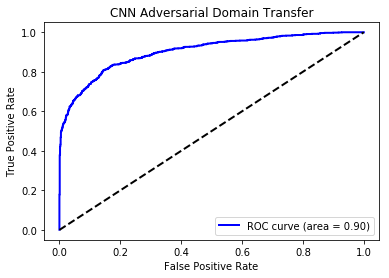

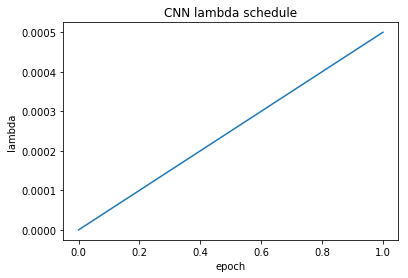

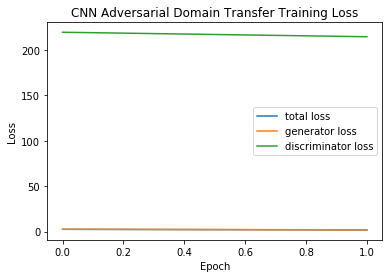

NameError: name 'lt' is not defined

In [25]:
print "training..."
for epoch in range(num_epochs):
    
    running_train_loss_tot = 0.0
    running_train_loss_gen = 0.0
    running_train_loss_dis = 0.0

    train_data_loader = torch.utils.data.DataLoader(
        train_data_combined, 
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4, 
        drop_last = True)
        
    model.train()
    domain_clf.train()

    scheduler_gen.step() 
    scheduler_dis.step()
        
    for bidx, batch in enumerate(tqdm(train_data_loader)):
      
        query_title = Variable(batch['query_title'])
        query_body = Variable(batch['query_body'])
        similar_title = Variable(batch['similar_title'])
        similar_body = Variable(batch['similar_body'])
        
        domain_label_flat = batch['domain_label'].numpy().ravel()
        domain_label = Variable(torch.from_numpy(domain_label_flat))

        random_title_list = []
        random_body_list = []
        for ridx in range(NUM_NEGATIVE): #100, number of random (negative) examples 
            random_title_name = 'random_title_' + str(ridx)
            random_body_name = 'random_body_' + str(ridx)
            random_title_list.append(Variable(batch[random_title_name]))
            random_body_list.append(Variable(batch[random_body_name]))

        if use_gpu:
            domain_label = domain_label.cuda()
            query_title, query_body = query_title.cuda(), query_body.cuda()
            similar_title, similar_body = similar_title.cuda(), similar_body.cuda()
            random_title_list = map(lambda item: item.cuda(), random_title_list)
            random_body_list = map(lambda item: item.cuda(), random_body_list)
        
        optimizer_gen.zero_grad() 
        optimizer_dis.zero_grad() 

        #question encoder

        #query title
        cnn_query_title = model(query_title)
        #query body
        cnn_query_body = model(query_body)
        cnn_query = (cnn_query_title + cnn_query_body)/2.0

        #similar title
        cnn_similar_title = model(similar_title)
        #similar body
        cnn_similar_body = model(similar_body)
        cnn_similar = (cnn_similar_title + cnn_similar_body)/2.0

        cnn_random_list = []
        for ridx in range(len(random_title_list)):
            #random title
            cnn_random_title = model(random_title_list[ridx])
            #random body
            cnn_random_body = model(random_body_list[ridx])

            cnn_random = (cnn_random_title + cnn_random_body)/2.0
            cnn_random_list.append(cnn_random)
        #end for
           
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
        score_pos = cosine_similarity(cnn_query, cnn_similar)

        score_list = []
        score_list.append(score_pos)
        for ridx in range(len(cnn_random_list)):
            score_neg = cosine_similarity(cnn_query, cnn_random_list[ridx])
            score_list.append(score_neg)

        X_scores = torch.stack(score_list, 1) #[batch_size, K=101]
        y_targets = Variable(torch.zeros(X_scores.size(0)).type(torch.LongTensor)) #[batch_size]
        if use_gpu:
            y_targets = y_targets.cuda()
        loss_gen = criterion_gen(X_scores, y_targets) #y_target=0


        #domain classifier
        y_clf_query = domain_clf(cnn_query)
        y_clf_similar = domain_clf(cnn_similar)

        y_clf_random_list = []
        for ridx in range(len(cnn_random_list)):
            cnn_random = cnn_random_list[ridx]
            y_clf_random = domain_clf(cnn_random)
            y_clf_random_list.append(y_clf_random)
        #end for

        loss_dis_query = criterion_dis(y_clf_query, domain_label)
        loss_dis_similar = criterion_dis(y_clf_similar, domain_label)

        loss_dis_random_list = []
        for ridx in range(len(y_clf_random_list)):
            y_clf_random = y_clf_random_list[ridx]
            loss_dis_random = criterion_dis(y_clf_random, domain_label)
            loss_dis_random_list.append(loss_dis_random)
        #end for
        loss_dis = loss_dis_query + loss_dis_similar + sum(loss_dis_random_list)

        #compute total loss
        lambda_k = lambda_schedule(epoch)
        if use_gpu:
            lambda_k = lambda_k.cuda()

        loss_tot = loss_gen - 1e-4 * loss_dis  #NOTE: keep lambda_k=1e-4 fixed

        loss_tot.backward()   #call backward() once
        optimizer_gen.step()  #min loss_tot: min loss_gen, max loss_dis
        optimizer_dis.step()  #min loss_dis: update domain clf params with negative learning rate
                
        running_train_loss_tot += loss_tot.cpu().data[0]        
        running_train_loss_gen += loss_gen.cpu().data[0]        
        running_train_loss_dis += loss_dis.cpu().data[0]        
        
        #gradient and weight norms 
        df_idx = bidx + epoch * batch_size
        grad_norm_df.loc[df_idx, 'df_idx'] = df_idx
        weight_norm_df.loc[df_idx, 'df_idx'] = df_idx
        
        grad_norm_df.loc[df_idx,'w1_grad_l2'] = torch.norm(domain_clf.fc1.weight.grad, 2).cpu().data[0] 
        weight_norm_df.loc[df_idx,'w1_data_l2'] = torch.norm(domain_clf.fc1.weight, 2).cpu().data[0]

        grad_norm_df.loc[df_idx,'w2_grad_l2'] = torch.norm(domain_clf.fc2.weight.grad, 2).cpu().data[0] 
        weight_norm_df.loc[df_idx,'w2_data_l2'] = torch.norm(domain_clf.fc2.weight, 2).cpu().data[0] 

        grad_norm_df.loc[df_idx,'w3_grad_l2'] = torch.norm(domain_clf.fc3.weight.grad, 2).cpu().data[0] 
        weight_norm_df.loc[df_idx,'w3_data_l2'] = torch.norm(domain_clf.fc3.weight, 2).cpu().data[0] 
        
        grad_norm_df.loc[df_idx,'w4_grad_l2'] = torch.norm(domain_clf.fc4.weight.grad, 2).cpu().data[0] 
        weight_norm_df.loc[df_idx,'w4_data_l2'] = torch.norm(domain_clf.fc4.weight, 2).cpu().data[0] 
        
    #end for
    lambda_list.append(lambda_k.cpu().data[0])
    training_loss_tot.append(running_train_loss_tot)
    training_loss_gen.append(running_train_loss_gen)
    training_loss_dis.append(running_train_loss_dis)
    print "epoch: %4d, training loss: %.4f" %(epoch+1, running_train_loss_tot)
    
    torch.save(model, SAVE_PATH + '/adversarial_domain_transfer.pt')
#end for
"""
print "loading pre-trained model..."
model = torch.load(SAVE_PATH + '/adversarial_domain_transfer.pt')
if use_gpu:
    print "found CUDA GPU..."
    model = model.cuda()
"""

print "scoring similarity between target questions..."
y_true, y_pred_lstm = [], []

test_data_loader_pos = torch.utils.data.DataLoader(
    target_test_pos_data, 
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4, 
    drop_last = True)
        
for batch in tqdm(test_data_loader_pos):

    q1_idx = batch['q1_idx']
    q1_title = Variable(batch['q1_title'])
    q1_body = Variable(batch['q1_body'])

    q2_idx = batch['q2_idx']
    q2_title = Variable(batch['q2_title'])
    q2_body = Variable(batch['q2_body'])

    if use_gpu:
        q1_title, q1_body = q1_title.cuda(), q1_body.cuda()
        q2_title, q2_body = q2_title.cuda(), q2_body.cuda()

    #q1 title
    cnn_q1_title = model(q1_title)
    #q1 body
    cnn_q1_body = model(q1_body)

    cnn_q1 = (cnn_q1_title + cnn_q1_body)/2.0

    #q2 title
    cnn_q2_title = model(q2_title)
    #q2 body
    cnn_q2_body = model(q2_body)
    cnn_q2 = (cnn_q2_title + cnn_q2_body)/2.0

    cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
    score_pos = cosine_similarity(cnn_q1, cnn_q2)

    score_pos_numpy = score_pos.cpu().data.numpy() #TODO: check (some scores are negative)

    y_true.extend(np.ones(batch_size)) #true label (similar)
    y_pred_lstm.extend(score_pos_numpy.tolist())
#end for        

test_data_loader_neg = torch.utils.data.DataLoader(
    target_test_neg_data, 
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4, 
    drop_last = True)
        
for batch in tqdm(test_data_loader_neg):
    q1_idx = batch['q1_idx']
    q1_title = Variable(batch['q1_title'])
    q1_body = Variable(batch['q1_body'])

    q2_idx = batch['q2_idx']
    q2_title = Variable(batch['q2_title'])
    q2_body = Variable(batch['q2_body'])

    if use_gpu:
        q1_title, q1_body = q1_title.cuda(), q1_body.cuda()
        q2_title, q2_body = q2_title.cuda(), q2_body.cuda()

    #q1 title
    cnn_q1_title = model(q1_title)
    #q1 body
    cnn_q1_body = model(q1_body)

    cnn_q1 = (cnn_q1_title + cnn_q1_body)/2.0

    #q2 title
    cnn_q2_title = model(q2_title)
    #q2 body
    cnn_q2_body = model(q2_body)

    cnn_q2 = (cnn_q2_title + cnn_q2_body)/2.0

    cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
    score_neg = cosine_similarity(cnn_q1, cnn_q2)

    score_neg_numpy = score_neg.cpu().data.numpy() #TODO: check (some scores are negative)

    y_true.extend(np.zeros(batch_size)) #true label (not similar)
    y_pred_lstm.extend(score_neg_numpy.tolist())
#end for        

roc_auc = roc_auc_score(y_true, y_pred_lstm)
print "area under ROC curve: ", roc_auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_lstm)

idx_fpr_thresh = np.where(fpr < 0.05)[0]
roc_auc_0p05fpr = auc(fpr[idx_fpr_thresh], tpr[idx_fpr_thresh])
print "ROC AUC(0.05): ", roc_auc_0p05fpr

#generate plots
plt.figure()
plt.plot(fpr, tpr, c='b', lw=2.0, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], c='k', lw=2.0, linestyle='--')
plt.title('CNN Adversarial Domain Transfer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig('../figures/cnn_domain_transfer_adversarial_lstm.png')
plt.show()

plt.figure()
plt.plot(lambda_list)
plt.title('CNN lambda schedule')
plt.xlabel('epoch')
plt.ylabel('lambda')
plt.savefig('../figures/cnn_domain_transfer_adversarial_lambda.png')
plt.show()

plt.figure()
plt.plot(training_loss_tot, label='total loss')
plt.plot(training_loss_gen, label='generator loss')
plt.plot(training_loss_dis, label='discriminator loss')
plt.title("CNN Adversarial Domain Transfer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('../figures/cnn_domain_transfer_adversarial_loss.png')
plt.show()

plt.figure()
plt.plot(grad_norm_df['w1_grad_l2'], c='r', alpha=0.8, label='w1 grad l2')
plt.plot(grad_norm_df['w2_grad_l2'], c='b', alpha=0.8, label='w2 grad l2')
plt.plot(grad_norm_df['w3_grad_l2'], c='g', alpha=0.8, label='w3 grad l2')
plt.plot(grad_norm_df['w4_grad_l2'], c='k', alpha=0.8, label='w4 grad l2')
plt.title('cnn domain classifier gradient norm')
plt.xlabel('num batches')
plt.ylabel('l2 norm')
plt.legend()
plt.savefig('../figures/cnn_domain_transfer_adversarial_gradient_norm.png')
plt.show()

plt.figure()
plt.plot(weight_norm_df['w1_data_l2'], c='r', alpha=0.8, label='w1 data l2')
plt.plot(weight_norm_df['w2_data_l2'], c='b', alpha=0.8, label='w2 data l2')
plt.plot(weight_norm_df['w3_data_l2'], c='g', alpha=0.8, label='w3 data l2')
plt.plot(weight_norm_df['w4_data_l2'], c='k', alpha=0.8, label='w4 data l2')
plt.title('cnn domain classifier weight norm')
plt.xlabel('num batches')
plt.ylabel('l2 norm')
plt.legend()
plt.savefig('../figures/cnn_domain_transfer_adversarial_weight_norm.png')
plt.show()

In [ ]:
print "fitting tf-idf vectorizer on source data..."
tic = time()
tfidf = TfidfVectorizer(tokenizer=tokenizer.tokenize, analyzer='word', ngram_range=(1,1))
tfidf.fit(source_text_df['title'].tolist() + source_text_df['body'].tolist())
toc = time()
print "elapsed time: %.2f sec" %(toc - tic)
vocab = tfidf.vocabulary_
print "source vocab size: ", len(vocab)

print "computing tf-idf vectors for target data..."
target_tfidf_dict = {}
for row_idx in tqdm(range(target_text_df.shape[0])):
    target_id = target_text_df.loc[row_idx, 'id']
    target_title_body = target_text_df.loc[row_idx,'title'] + ' ' + target_text_df.loc[row_idx,'body']
    target_tfidf = tfidf.transform([target_title_body])
    target_tfidf_dict[target_id] = target_tfidf
#end for

In [ ]:
print "scoring similarity between target questions..."
y_true, y_pred = [], []
for row_idx in tqdm(range(target_pos_df.shape[0])):
    y_true.append(1) #true label (similar)
    
    q1_idx = target_pos_df.loc[row_idx,'id']
    q2_idx = target_pos_df.loc[row_idx,'pos']

    score = cosine_similarity(target_tfidf_dict[q1_idx], target_tfidf_dict[q2_idx])
    y_pred.append(score[0][0])
#end for

for row_idx in tqdm(range(target_neg_df.shape[0])):
    y_true.append(0) #true label (not similar)
    
    q1_idx = target_neg_df.loc[row_idx,'id']
    q2_idx = target_neg_df.loc[row_idx,'neg']

    score = cosine_similarity(target_tfidf_dict[q1_idx], target_tfidf_dict[q2_idx])
    y_pred.append(score[0][0])
#end for

roc_auc = roc_auc_score(y_true, y_pred)
print "area under ROC curve: ", roc_auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

idx_fpr_thresh = np.where(fpr < 0.05)[0]
roc_auc_0p05fpr = auc(fpr[idx_fpr_thresh], tpr[idx_fpr_thresh])
print "ROC AUC(0.05): ", roc_auc_0p05fpr

y_df = pd.DataFrame()
y_df['y_pred'] = y_pred
y_df['y_true'] = y_true
bins = np.linspace(min(y_pred)-0.1, max(y_pred)+0.1, 100)

In [ ]:
#generate plots
plt.figure()
plt.plot(fpr, tpr, c='b', lw=2.0, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], c='k', lw=2.0, linestyle='--')
plt.title('TF-IDF Domain Transfer')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

plt.figure()
sns.distplot(y_df[y_df['y_true']==1]['y_pred'], bins, kde=True, norm_hist=True, color='b', label='pos class')
sns.distplot(y_df[y_df['y_true']==0]['y_pred'], bins, kde=True, norm_hist=True, color='r', label='neg class')
plt.xlim([0,1])
plt.legend(loc='upper right')
plt.ylabel('normalized histogram')
plt.title('pos and neg class separation')
plt.show()

In [ ]:
#training parameters
num_epochs = 2 #16
batch_size = 16 

#model parameters
embed_num = len(word_to_idx)
embed_dim = len(embeddings[0])
kernel_num = 200  #TODO: tune
kernel_sizes = range(2,6)
learning_rate = 1e-3 
weight_decay = 1e-5

class  CNN(nn.Module):
    def __init__(self, embed_num, embed_dim, kernel_num, kernel_sizes):
        super(CNN,self).__init__()
        V = embed_num
        D = embed_dim
        Ci = 1            #input channel
        Co = kernel_num   #depth
        Ks = kernel_sizes #height of each filter

        self.embed = nn.Embedding(V, D)
        self.embed.weight.data = torch.from_numpy(embeddings)
        self.convs1 = nn.ModuleList([nn.Conv2d(Ci, Co, (K, D)) for K in Ks])

    def forward(self, x):
        x = self.embed(x) # (N,W,D)
        x = x.unsqueeze(1) # (N,Ci,W,D)
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] #[(N,Co,W), ...]*len(Ks)
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x] #[(N,Co), ...]*len(Ks)
        x = torch.cat(x, 1)
        return x

model = CNN(embed_num, embed_dim, kernel_num, kernel_sizes)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print "found CUDA GPU..."
    model = model.cuda()

print model

In [ ]:
#define loss and optimizer
criterion = nn.MultiMarginLoss(p=1, margin=0.4, size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5) #half learning rate every 4 epochs

train_data_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4, 
        drop_last = True)
        
model.train()
scheduler.step()
    
for batch in tqdm(train_data_loader):
    query_title = Variable(batch['query_title'])
    query_body = Variable(batch['query_body'])
    cnn_query_title = model(query_title)
    cnn_query_body = model(query_body)
    print query_title.data.shape
    print query_body.data.shape
    print cnn_query_title.data.shape
    print cnn_query_body.data.shape
    print "---"

In [ ]:
#define loss and optimizer
criterion = nn.MultiMarginLoss(p=1, margin=0.4, size_average=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = StepLR(optimizer, step_size=4, gamma=0.5) #half learning rate every 4 epochs

learning_rate_schedule = [] 
training_loss, validation_loss, test_loss = [], [], []

print "training..."
for epoch in range(num_epochs):
    
    running_train_loss = 0.0
    
    train_data_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size = batch_size,
        shuffle = True,
        num_workers = 4, 
        drop_last = True)
        
    model.train()
    scheduler.step()
        
    for batch in tqdm(train_data_loader):
    
        query_title = Variable(batch['query_title'])
        query_body = Variable(batch['query_body'])
        similar_title = Variable(batch['similar_title'])
        similar_body = Variable(batch['similar_body'])

        random_title_list = []
        random_body_list = []
        for ridx in range(NUM_NEGATIVE): #number of random negative examples
            random_title_name = 'random_title_' + str(ridx)
            random_body_name = 'random_body_' + str(ridx)
            random_title_list.append(Variable(batch[random_title_name]))
            random_body_list.append(Variable(batch[random_body_name]))

        if use_gpu:
            query_title, query_body = query_title.cuda(), query_body.cuda()
            similar_title, similar_body = similar_title.cuda(), similar_body.cuda()
            random_title_list = map(lambda item: item.cuda(), random_title_list)
            random_body_list = map(lambda item: item.cuda(), random_body_list)
        
        optimizer.zero_grad()

        cnn_query_title = model(query_title)
        cnn_query_body = model(query_body)
        cnn_query = (cnn_query_title + cnn_query_body)/2.0

        cnn_similar_title = model(similar_title)
        cnn_similar_body = model(similar_body)
        cnn_similar = (cnn_similar_title + cnn_similar_body)/2.0

        cnn_random_list = []
        for ridx in range(len(random_title_list)):
            cnn_random_title = model(random_title_list[ridx])
            cnn_random_body = model(random_body_list[ridx])
            cnn_random = (cnn_random_title + cnn_random_body)/2.0
            cnn_random_list.append(cnn_random)
        #end for
           
        cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
        score_pos = cosine_similarity(cnn_query, cnn_similar)

        score_list = []
        score_list.append(score_pos)
        for ridx in range(len(cnn_random_list)):
            score_neg = cosine_similarity(cnn_query, cnn_random_list[ridx])
            score_list.append(score_neg)

        X_scores = torch.stack(score_list, 1) #[batch_size, K=101]
        print X_scores
        y_targets = Variable(torch.zeros(X_scores.size(0)).type(torch.LongTensor)) #[batch_size]
        if use_gpu:
            y_targets = y_targets.cuda()
        loss = criterion(X_scores, y_targets) #y_target=0
        loss.backward()
        optimizer.step()
                
        running_train_loss += loss.cpu().data[0]        
        
    #end for

    training_loss.append(running_train_loss)
    learning_rate_schedule.append(scheduler.get_lr())
    print "epoch: %4d, training loss: %.4f" %(epoch+1, running_train_loss)
    
    torch.save(model, SAVE_PATH + SAVE_NAME)

    #early stopping
    patience = 4
    min_delta = 0.1
    if epoch == 0:
        patience_cnt = 0
    elif epoch > 0 and training_loss[epoch-1] - training_loss[epoch] > min_delta:
        patience_cnt = 0
    else:
        patience_cnt += 1

    if patience_cnt > patience:
        print "early stopping..."
        break
#end for
"""
print "loading pre-trained model..."
model = torch.load(SAVE_PATH)
if use_gpu:
    print "found CUDA GPU..."
    model = model.cuda()
"""

In [ ]:
print "scoring test questions..."
running_test_loss = 0.0

test_data_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size = batch_size,
    shuffle = False,
    num_workers = 4, 
    drop_last = True)
        
model.eval()

for batch in tqdm(test_data_loader):
    print "here!"
    query_idx = batch['query_idx']
    query_title = Variable(batch['query_title'])
    query_body = Variable(batch['query_body'])
    similar_title = Variable(batch['similar_title'])
    similar_body = Variable(batch['similar_body'])

    random_title_list = []
    random_body_list = []
    for ridx in range(20): #number of retrieved (bm25) examples
        random_title_name = 'random_title_' + str(ridx)
        random_body_name = 'random_body_' + str(ridx)
        random_title_list.append(Variable(batch[random_title_name]))
        random_body_list.append(Variable(batch[random_body_name]))

    if use_gpu:
        query_title, query_body = query_title.cuda(), query_body.cuda()
        similar_title, similar_body = similar_title.cuda(), similar_body.cuda()
        random_title_list = map(lambda item: item.cuda(), random_title_list)
        random_body_list = map(lambda item: item.cuda(), random_body_list)
    
    cnn_query_title = model(query_title)
    cnn_query_body = model(query_body)
    cnn_query = (cnn_query_title + cnn_query_body)/2.0

    cnn_similar_title = model(similar_title)
    cnn_similar_body = model(similar_body)
    cnn_similar = (cnn_similar_title + cnn_similar_body)/2.0

    cnn_random_list = []
    for ridx in range(len(random_title_list)):
        cnn_random_title = model(random_title_list[ridx])
        cnn_random_body = model(random_body_list[ridx])
        cnn_random = (cnn_random_title + cnn_random_body)/2.0
        cnn_random_list.append(cnn_random)
    #end for
           
    cosine_similarity = nn.CosineSimilarity(dim=1, eps=1e-6)
    score_pos = cosine_similarity(cnn_query, cnn_similar)

    score_list = []
    score_list.append(score_pos)
    for ridx in range(len(cnn_random_list)):
        score_neg = cosine_similarity(cnn_query, cnn_random_list[ridx])
        score_list.append(score_neg)
    
    print "haha!"
    X_scores = torch.stack(score_list, 1) #[batch_size, K=101]
    print X_scores
    y_targets = Variable(torch.zeros(X_scores.size(0)).type(torch.LongTensor)) #[batch_size]
    if use_gpu:
        y_targets = y_targets.cuda()
    loss = criterion(X_scores, y_targets) #y_target=0
    running_test_loss += loss.cpu().data[0]        
    
    #save scores to data-frame
    cnn_query_idx = query_idx.numpy()
    cnn_retrieved_scores = X_scores.data.numpy()[:,1:] #skip positive score
    for row, qidx in enumerate(cnn_query_idx):
        test_idx_df.loc[test_idx_df['query_id'] == qidx, 'cnn_score'] = " ".join(cnn_retrieved_scores[row,:].astype('str'))
#end for        
 

In [ ]:
print cnn_retrieved_scores[0:10,:].astype('str')

In [ ]:
print test_idx_df.loc[6,'random_id']
print test_idx_df.loc[6,'bm25_score']

In [ ]:
#save scored data frame
#test_idx_df.to_csv(SAVE_PATH + '/test_idx_df_scored_cnn.csv', header=True)

print "computing ranking metrics..."
cnn_mrr_test = compute_mrr(test_idx_df, score_name='cnn_score')
print "cnn MRR (test): ", np.mean(cnn_mrr_test)

cnn_pr1_test = precision_at_k(test_idx_df, K=1, score_name='cnn_score')
print "cnn P@1 (test): ", np.mean(cnn_pr1_test)

cnn_pr5_test = precision_at_k(test_idx_df, K=5, score_name='cnn_score')
print "cnn P@5 (test): ", np.mean(cnn_pr5_test)

cnn_map_test = compute_map(test_idx_df, score_name='cnn_score')
print "cnn map (test): ", np.mean(cnn_map_test)

In [ ]:
#generate plots
plt.figure()
plt.plot(training_loss, label='Adam')
plt.title("CNN Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.savefig('../figures/cnn_training_loss.png')

plt.figure()
plt.plot(learning_rate_schedule, label='learning rate')
plt.title("CNN learning rate schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.legend()
plt.savefig('../figures/cnn_learning_rate_schedule.png')

"""
plt.figure()
plt.plot(validation_loss, label='Adam')
plt.title("CNN Model Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.savefig('../figures/cnn_validation_loss.png')
"""